# Sharpe Ratio calculation

For this example assume that we have bought the IGE stock at nov 26 2001 and held until nov 14 2007.
The risk free interest is 4%.

We need to calculate the sharpe ratio which is

excessRet = daily% ret - 4%
avg(excessRet)/std(excessRet)

and to get the yearly return we need to multiply by the amt of trading days which have been sqrt.

In [35]:
import yfinance as yf
import math

ticker_yahoo = yf.Ticker('IGE')

# The auto_adjust is set to true by default, but adding it here just for explicitness.
# We want the dividends and the splits to be accounted for
df = ticker_yahoo.history(start="2001-11-26", end="2007-11-14", auto_adjust=True)
df = df.sort_values(by='Date')
    
merge_period = 255 #1 year - or 255 trading days

# Divide the 4% by the anual trading window, since we want to compare daily gains to daily gains
excess_return = df['Close'].pct_change() - 0.04/merge_period

sharpe_ratio = math.sqrt(merge_period) * (excess_return.mean()/excess_return.std())
print(sharpe_ratio)

0.7937843203785948


# Long-Short Market neutral strategy

This is an extension of the previous excercise, with the small change that we are also shorting SPY (Standard and Poors as Hedge).
means that we won't compare against the market rate of 4%

In [46]:
tickers = yf.Tickers('IGE SPY')

ige = tickers.tickers["IGE"].history(start="2001-11-26", end="2007-11-14", auto_adjust=True)
ige = ige.sort_values(by='Date')

spy = tickers.tickers["SPY"].history(start="2001-11-26", end="2007-11-14", auto_adjust=True)
spy = spy.sort_values(by='Date')


## the excess return here would be counted by summing the returns daily from both of them, but we have to invert spy since its shorting

merge_period = 255 #1 year - or 255 trading days

# We divide by 2 because we have twice the capital, since the shorting automatically borrows us the price of the stock at that point.
excess_return = ((ige['Close'].pct_change() - spy['Close'].pct_change())/2)/merge_period

sharpe_ratio = math.sqrt(merge_period) * (excess_return.mean()/excess_return.std())
print(sharpe_ratio)

0.7738344503213246


# Maximum Drawdown and Drawdown Duration

We start by finding the high watermark, which is the cumulative sum of returns until that point.

In [196]:
import numpy as np

tickers = yf.Tickers('IGE SPY')

ige = tickers.tickers["IGE"].history(start="2001-11-26", end="2007-11-14", auto_adjust=True)
ige = ige.sort_values(by='Date')

spy = tickers.tickers["SPY"].history(start="2001-11-26", end="2007-11-14", auto_adjust=True)
spy = spy.sort_values(by='Date')


## the excess return here would be counted by summing the returns daily from both of them, but we have to invert spy since its shorting

# We divide by 2 because we have twice the capital, since the shorting automatically borrows us the price of the stock at that point.
excess_return = ((ige['Close'].pct_change() - spy['Close'].pct_change())/2)

cumulated_ret = np.cumsum(excess_return)
cumulated_ret = cumulated_ret.to_frame()

Below calculates the drawdown by first finding the peak and then finding the local minimum.

In [292]:
last_peak_val = 0
last_peak_pos = np.nan
last_trough_val = np.nan
cum_mask = cumulated_ret.copy()

# iterate throught the list
# find the peak (value where -1 is lower/nan and +1 lower/equal/nan) 
# and the local minimum (value lower than the peak) - where (value where -1 is higher/nan and +1 higher/equal/nan)
# we keep the last_max_val and the ago
# ago will get nulled everytime we hit a peak
# it will get attached only if the found trough is the lowest (lower or equal then the last one)

is_peak = []
is_trough = []
drawdown_dur = []
drawdown_val = []

ago_2_val = np.nan
ago_1_val = np.nan
i=-1;

# Add extra 1 row so we can get also the last element evaluated
cum_mask.loc[cum_mask.index[-1]+pd.Timedelta(days=1)] = np.nan

for row in cum_mask.itertuples():
    i+=1
    if i==0:
        ago_1_val = row.Close
        continue

    val = row.Close

    is_1_peak = ago_1_val > last_peak_val and (np.isnan(ago_2_val) or ago_2_val < ago_1_val) and (np.isnan(val) or val <= ago_1_val)

    is_lowest_min = (np.isnan(last_trough_val) or ago_1_val < last_trough_val)
    is_below_peak = not np.isnan(ago_1_val) and ago_1_val < last_peak_val
    is_v_shape = (np.isnan(ago_2_val) or ago_2_val >= ago_1_val) and (np.isnan(val) or val > ago_1_val)
    is_1_through = not np.isnan(last_peak_pos) and is_below_peak and is_lowest_min and is_v_shape

    if is_1_peak:
        last_peak_val = ago_1_val
        last_peak_pos = i-1
        last_trough_val = np.nan
        
        is_peak.append(True)
        is_trough.append(False)
        drawdown_dur.append(np.nan)
        drawdown_val.append(np.nan)
    elif is_1_through:
        last_trough_val = ago_1_val
        drawdown = last_peak_val - last_trough_val
        duration = i - 1 - last_peak_pos
        
        is_peak.append(False)
        is_trough.append(True)
        drawdown_dur.append(duration)
        drawdown_val.append(drawdown)
    else:
        is_peak.append(False)
        is_trough.append(False)
        drawdown_dur.append(np.nan)
        drawdown_val.append(np.nan)

    ago_2_val = ago_1_val
    ago_1_val = row.Close

# Remove the last row that was added so that we can run 1 more loop
cum_mask = cum_mask.iloc[:-1]

is_peak = pd.Series(is_peak, index=cum_mask.index)
is_trough = pd.Series(is_trough, index=cum_mask.index)
drawdown_dur = pd.Series(drawdown_dur, index=cum_mask.index)
drawdown_val = pd.Series(drawdown_val, index=cum_mask.index)


cum_mask['is_peak'] = is_peak
cum_mask['is_trough'] = is_trough
cum_mask['drawdown_dur'] = drawdown_dur
cum_mask['drawdown_val'] = drawdown_val


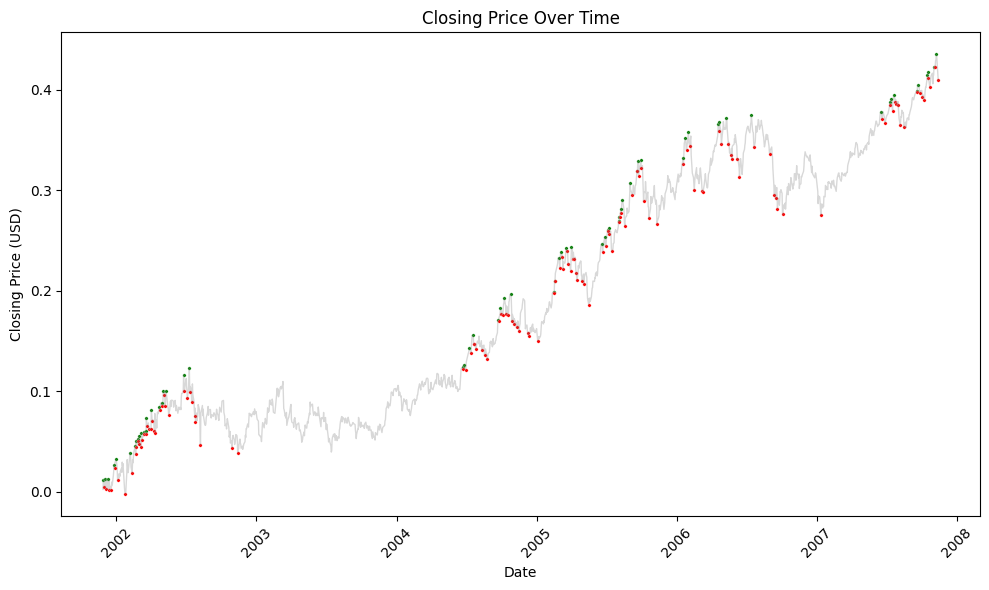

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

sns.lineplot(x='Date', y='Close', color="gray", alpha=0.3, linewidth=1, data=cum_mask)
sns.scatterplot(x='Date', y='Close', color="green", s=6, data=cum_mask[cum_mask['is_peak'] == True])
sns.scatterplot(x='Date', y='Close', color="red", s=6, data=cum_mask[cum_mask['is_trough'] == True])

# Add informative titles and labels
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45) # Rotate date labels for better readability

plt.tight_layout()

In [294]:
id_drawdown_val_max = cum_mask['drawdown_val'].idxmax()

print(cum_mask.loc[id_drawdown_val_max])

Close           0.275329
is_peak            False
is_trough           True
drawdown_dur       124.0
drawdown_val    0.099231
Name: 2007-01-11 00:00:00-05:00, dtype: object


The maximum drawdown seems to be start of 2007  after 4 months of dropping with slight recovery.

## Direction POC (discontinued)

In [286]:
# Calculates the directions only

mask = cumulated_ret['Close'] > cumulated_ret['Close'].shift(1)
mask2 = cumulated_ret['Close'].cummax()

cum_mask = cumulated_ret.copy()
cum_mask['LocalMax'] = mask
cum_mask['LocalMaxVal'] = mask2

is_peak = cum_mask['Close'] == cum_mask['Close'].cummax()
group_id = is_peak.cumsum()
cum_mask['PeakGroup'] = group_id
cum_mask['IsPeak'] = is_peak
cumulative_min_between_peaks = cum_mask.groupby(group_id)['Close'].cummin()
cum_mask['LocalMinBetweenPeaks'] = cumulative_min_between_peaks

is_local_trough = cum_mask['Close'] == cum_mask.groupby(cum_mask['IsPeak'])['Close'].cummin()
cum_mask['IsThrough'] = is_local_trough

print(cum_mask.head(10))
cumulated_ret = cum_mask

# we can get the drawdown by storing the min and max values and by grouping by the max value.
# Starting at the max value and ending at the max value that is higher than the current max

Now that we have the Peaks and Throughts we can find the drawdown as pairs between Peak and next trought.

The drawdown would be the longest in days Peak to Trought and as well the Close diff.

ValueError: Could not interpret value `LocalMax` for `hue`. An entry with this name does not appear in `data`.

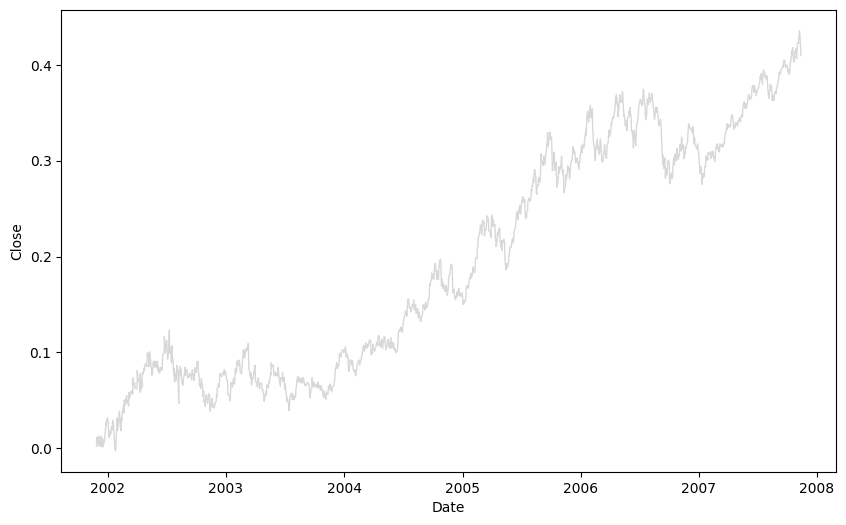

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

sns.lineplot(x='Date', y='Close', color="gray", alpha=0.3, linewidth=1, data=cumulated_ret) # use .loc[:'2002-01-01'] to use smaller timeframe
sns.scatterplot(x='Date', y='Close', hue='LocalMax', s=6, data=cumulated_ret)

# Add informative titles and labels
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45) # Rotate date labels for better readability

plt.tight_layout()

## Next section